# Tutorial 27: HERC with Equal Weights within Clusters (HERC2)

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  25 of 25 completed


In [2]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-2.0257%,0.4057%,0.4035%,1.9692%,0.0180%,0.9305%,0.3678%,0.5783%,0.9483%,-1.1953%,...,1.5881%,0.0212%,2.8236%,0.9758%,0.6987%,1.7539%,-0.1730%,0.2410%,1.3735%,-1.0857%
2016-01-06,-11.4863%,-1.5879%,0.2412%,-1.7557%,-0.7727%,-1.2473%,-0.1736%,-1.1239%,-3.5867%,-0.9551%,...,0.5547%,0.0212%,0.1592%,-1.5646%,0.3108%,-1.0155%,-0.7653%,-3.0048%,-0.9035%,-2.9145%
2016-01-07,-5.1388%,-4.1922%,-1.6573%,-2.7699%,-1.1047%,-1.9769%,-1.2207%,-0.8856%,-4.6058%,-2.5394%,...,-2.2066%,-3.0310%,-1.0410%,-3.1557%,-1.6148%,-0.2700%,-2.2845%,-2.0570%,-0.5492%,-3.0019%
2016-01-08,0.2736%,-2.2705%,-1.6037%,-2.5425%,0.1099%,-0.2241%,0.5707%,-1.6402%,-1.7642%,-0.1649%,...,-0.1539%,-1.1366%,-0.7308%,-0.1448%,0.0895%,-3.3839%,-0.1117%,-1.1387%,-0.9720%,-1.1254%
2016-01-11,-4.3384%,0.1692%,-1.6851%,-1.0215%,0.0914%,-1.1792%,0.5674%,0.5287%,0.6616%,0.0330%,...,1.6436%,0.0000%,0.9869%,-0.1451%,1.2224%,1.4570%,0.5367%,-0.4608%,0.5800%,-1.9919%


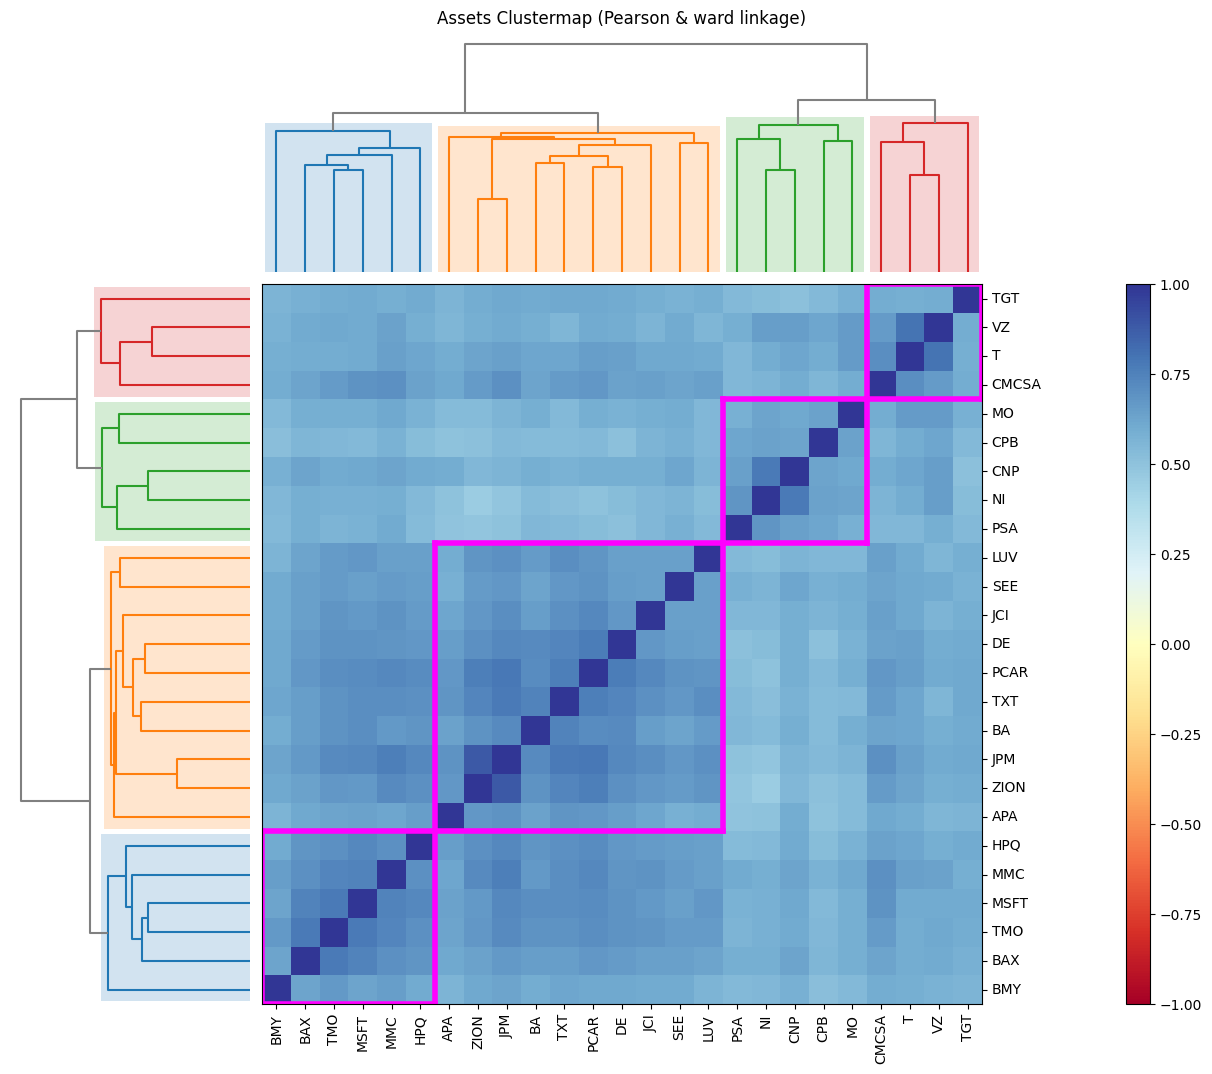

In [3]:
import riskfolio as rp

# Plotting Assets Clusters

ax = rp.plot_clusters(returns=Y,
                      codependence='pearson',
                      linkage='ward',
                      k=None,
                      max_k=10,
                      leaf_order=True,
                      dendrogram=True,
                      #linecolor='tab:purple',
                      ax=None)

## 2. Estimating HERC and HERC2 Portfolios

HERC2 포트폴리오는 원래 HERC 포트폴리오의 수정된 버전으로, 클러스터 내 가중치를 원래 HERC 포트폴리오에서 사용된 단순 위험 균형 방식이 아닌 동일하게 만듭니다.

### 2.1 Calculating the HERC and HERC2 portfolios

In [4]:
# Building the portfolio object
port = rp.HCPortfolio(returns=Y)

# Estimate optimal portfolio:

codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'ward' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic
leaf_order = True # Consider optimal order of leafs in dendrogram

w1 = port.optimization(model='HERC',
                       codependence=codependence,
                       method_cov='hist',
                       rm=rm,
                       rf=rf,
                       linkage=linkage,
                       max_k=max_k,
                       leaf_order=leaf_order)

w2 = port.optimization(model='HERC2',
                       codependence=codependence,
                       method_cov='hist',
                       rm=rm,
                       rf=rf,
                       linkage=linkage,
                       max_k=max_k,
                       leaf_order=leaf_order)

w = pd.concat([w1, w2], axis=1)
w.columns = ['HERC', 'HERC2']

display(w.sort_values(by='HERC', ascending=False).style.format("{:.2%}").background_gradient(cmap='YlGn'))


,HERC,HERC2
VZ,8.79%,6.39%
T,7.74%,6.39%
CNP,7.64%,6.33%
NI,7.37%,6.33%
MMC,7.24%,4.07%
PSA,6.94%,6.33%
CMCSA,5.84%,6.39%
MO,5.77%,6.33%
BAX,4.55%,4.07%
TMO,4.05%,4.07%


### 2.2 Plotting Risk Contribution

<Axes: title={'center': 'Risk (Standard Deviation) Contribution per Asset'}>

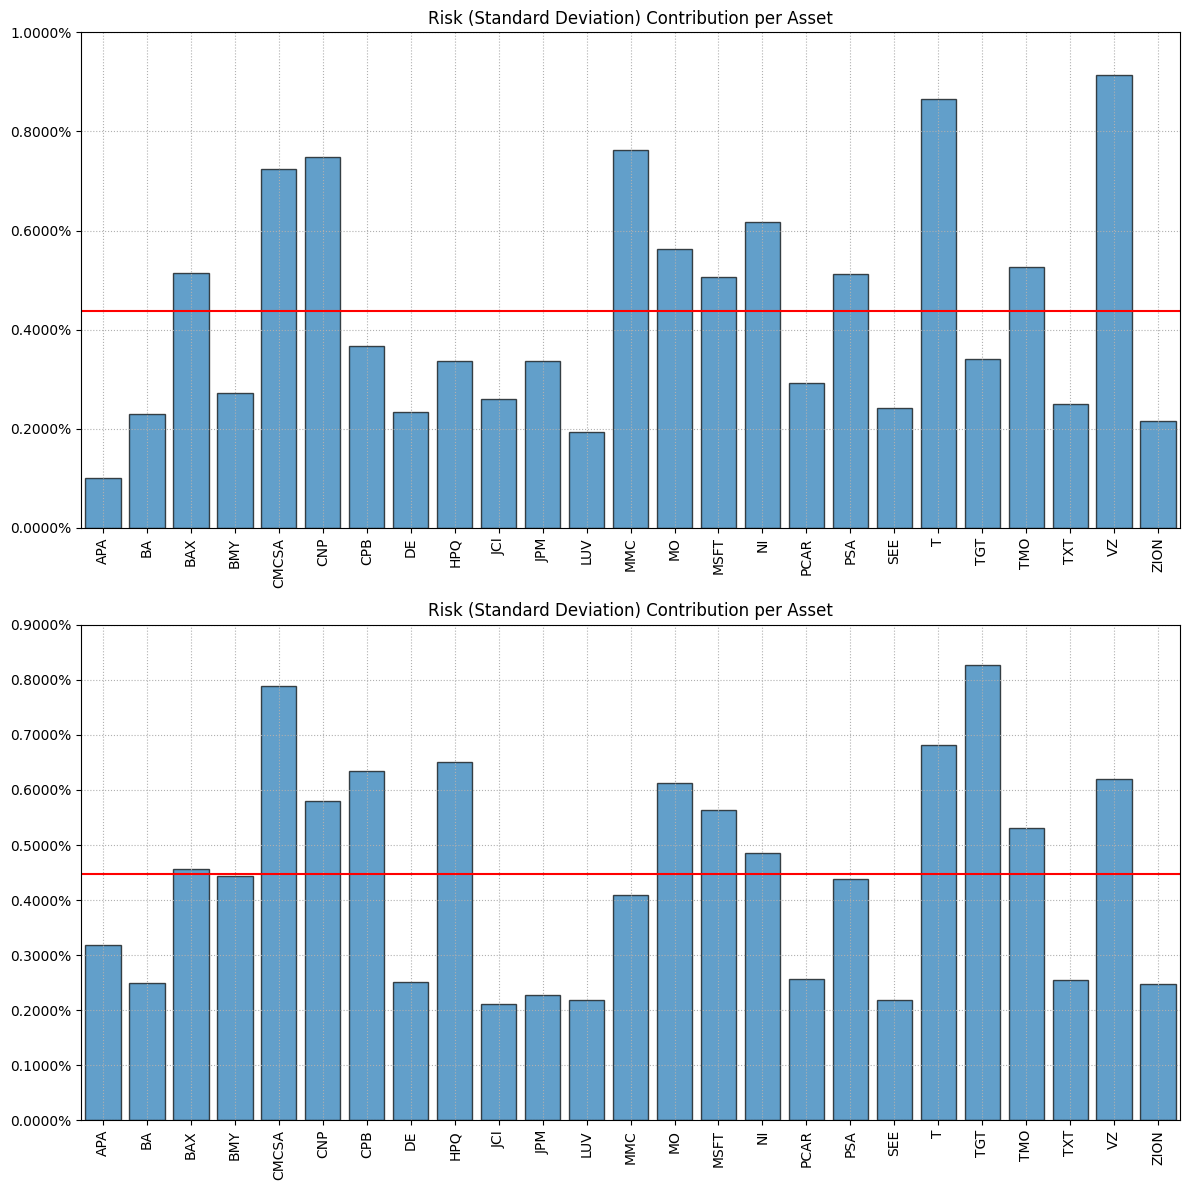

In [5]:
import matplotlib.pyplot as plt

# Plotting the risk contribution per asset

mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

fig, ax = plt.subplots(2,1, figsize=(12, 12))

ax = np.ravel(ax)
rp.plot_risk_con(w=w1,
                 cov=cov,
                 returns=returns,
                 rm=rm,
                 rf=0,
                 alpha=0.05,
                 color="tab:blue",
                 height=6,
                 width=10,
                 t_factor=252,
                 ax=ax[0])

rp.plot_risk_con(w=w2,
                 cov=cov,
                 returns=returns,
                 rm=rm,
                 rf=0,
                 alpha=0.05,
                 color="tab:blue",
                 height=6,
                 width=10,
                 t_factor=252,
                 ax=ax[1])

### 2.3 Calculate Optimal HERC and HERC2 Portfolios for Several Covariance Estimators

In [6]:
# Covariance estimators available:
#
# 'hist': use historical estimates.
# 'ewma1'': use ewma with adjust=True, see `EWM <https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows>`_ for more details.
# 'ewma2': use ewma with adjust=False, see `EWM <https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows>`_ for more details.
# 'ledoit': use the Ledoit and Wolf Shrinkage method.
# 'oas': use the Oracle Approximation Shrinkage method.
# 'shrunk': use the basic Shrunk Covariance method.

models = ['HERC'] * 6 + ['HERC2'] * 6
covariances = ['hist', 'ewma1', 'ewma2', 'ledoit', 'oas', 'shrunk'] * 2

w_s = pd.DataFrame([])

for i,j in zip(models, covariances):
    w = port.optimization(model=i,
                          codependence=codependence,
                          method_cov=j,
                          rm=rm,
                          rf=rf,
                          linkage=linkage,
                          max_k=max_k,
                          leaf_order=leaf_order)

    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = zip(models, covariances)

In [7]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,"('HERC', 'hist')","('HERC', 'ewma1')","('HERC', 'ewma2')","('HERC', 'ledoit')","('HERC', 'oas')","('HERC', 'shrunk')","('HERC2', 'hist')","('HERC2', 'ewma1')","('HERC2', 'ewma2')","('HERC2', 'ledoit')","('HERC2', 'oas')","('HERC2', 'shrunk')"
APA,0.64%,0.64%,0.64%,0.64%,0.64%,0.64%,1.84%,1.84%,1.84%,1.84%,1.84%,1.84%
BA,1.73%,1.73%,1.73%,1.73%,1.73%,1.73%,1.84%,1.84%,1.84%,1.84%,1.84%,1.84%
BAX,4.55%,4.55%,4.55%,4.55%,4.55%,4.55%,4.07%,4.07%,4.07%,4.07%,4.07%,4.07%
BMY,2.65%,2.65%,2.65%,2.65%,2.65%,2.65%,4.07%,4.07%,4.07%,4.07%,4.07%,4.07%
CMCSA,5.84%,5.84%,5.84%,5.84%,5.84%,5.84%,6.39%,6.39%,6.39%,6.39%,6.39%,6.39%
CNP,7.64%,7.64%,7.64%,7.64%,7.64%,7.64%,6.33%,6.33%,6.33%,6.33%,6.33%,6.33%
CPB,3.90%,3.90%,3.90%,3.90%,3.90%,3.90%,6.33%,6.33%,6.33%,6.33%,6.33%,6.33%
DE,1.73%,1.73%,1.73%,1.73%,1.73%,1.73%,1.84%,1.84%,1.84%,1.84%,1.84%,1.84%
HPQ,2.25%,2.25%,2.25%,2.25%,2.25%,2.25%,4.07%,4.07%,4.07%,4.07%,4.07%,4.07%
JCI,2.25%,2.25%,2.25%,2.25%,2.25%,2.25%,1.84%,1.84%,1.84%,1.84%,1.84%,1.84%


<Axes: >

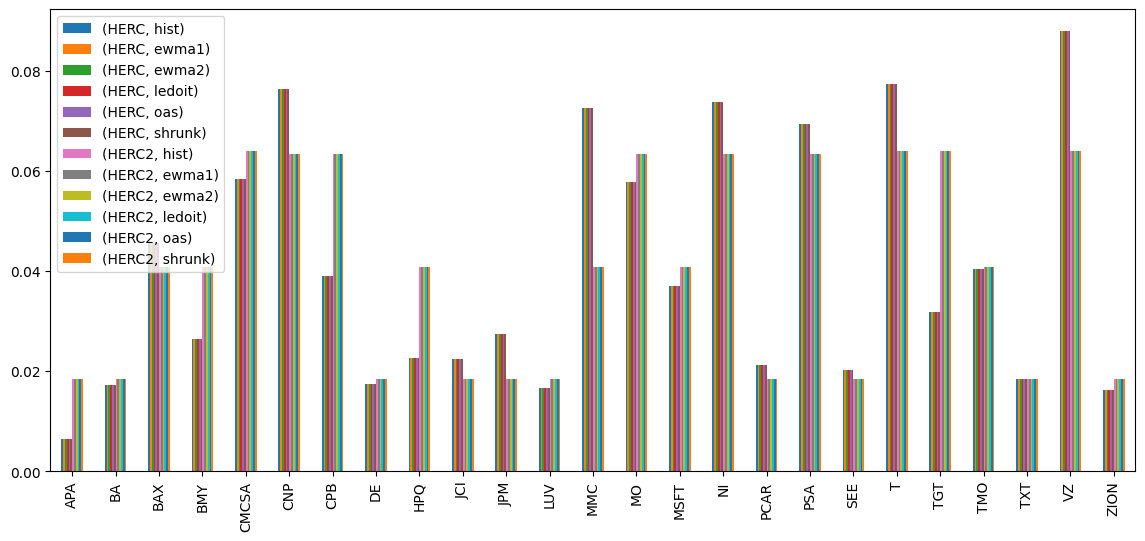

In [8]:
# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)